# Bird Species Classification

Cho tập data Bird Species gồm ~84k ảnh của 525 nhãn, mỗi nhãn là tên khoa học của 1 loại chim tại Kaggle: https://www.kaggle.com/datasets/gpiosenka/100-bird-species. Yêu cầu:

1. Sử dụng các kiến thức đã học (CNN, Transfer Learning), tạo 1 cấu trúc mô hình phù hợp để phân loại 525 nhãn.


## 1. Load Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

In [2]:
# Thiết lập các tham số
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Đường dẫn đến tập dữ liệu
data_dir = "/kaggle/input/100-bird-species/"

# Áp dụng các biến đổi cho dữ liệu huấn luyện và kiểm thử
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [3]:
# Tạo DataLoader cho dữ liệu huấn luyện và kiểm thử 
# ImageFolder => label encoder already included
train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=transform_train)
test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=transform_test)
valid_dataset = datasets.ImageFolder(root=data_dir + 'valid', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
# Số lượng mẫu
len(train_dataset)

84635

In [5]:
# Print all the classes
classes = train_dataset.classes
print("Len of train Classes:",len(classes))
print("Len of test Classes:",len(test_dataset.classes))

# Get the class-to-index mapping
class_to_idx = train_dataset.class_to_idx

# Print classes with their indices
for class_name, class_idx in class_to_idx.items():
    print(f"Class: {class_name}, Index: {class_idx}")

Len of train Classes: 525
Len of test Classes: 525
Class: ABBOTTS BABBLER, Index: 0
Class: ABBOTTS BOOBY, Index: 1
Class: ABYSSINIAN GROUND HORNBILL, Index: 2
Class: AFRICAN CROWNED CRANE, Index: 3
Class: AFRICAN EMERALD CUCKOO, Index: 4
Class: AFRICAN FIREFINCH, Index: 5
Class: AFRICAN OYSTER CATCHER, Index: 6
Class: AFRICAN PIED HORNBILL, Index: 7
Class: AFRICAN PYGMY GOOSE, Index: 8
Class: ALBATROSS, Index: 9
Class: ALBERTS TOWHEE, Index: 10
Class: ALEXANDRINE PARAKEET, Index: 11
Class: ALPINE CHOUGH, Index: 12
Class: ALTAMIRA YELLOWTHROAT, Index: 13
Class: AMERICAN AVOCET, Index: 14
Class: AMERICAN BITTERN, Index: 15
Class: AMERICAN COOT, Index: 16
Class: AMERICAN DIPPER, Index: 17
Class: AMERICAN FLAMINGO, Index: 18
Class: AMERICAN GOLDFINCH, Index: 19
Class: AMERICAN KESTREL, Index: 20
Class: AMERICAN PIPIT, Index: 21
Class: AMERICAN REDSTART, Index: 22
Class: AMERICAN ROBIN, Index: 23
Class: AMERICAN WIGEON, Index: 24
Class: AMETHYST WOODSTAR, Index: 25
Class: ANDEAN GOOSE, Inde

In [6]:
# In input và labels của batch đầu tiên
for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Print the current batch
    print(f"Batch {batch_idx + 1} - Inputs: {inputs}, Labels: {labels}")

    # Print the size of the current batch (number of samples in the batch)
    print(f"Batch {batch_idx + 1} - Batch Size: {len(inputs)}")

    # Break after printing the first 5 batches
    if batch_idx == 0:
        break

Batch 1 - Inputs: tensor([[[[0.4196, 0.5647, 0.5843,  ..., 0.2431, 0.2588, 0.2745],
          [0.3765, 0.5098, 0.5490,  ..., 0.2353, 0.2471, 0.2667],
          [0.3176, 0.4314, 0.4824,  ..., 0.2275, 0.2314, 0.2549],
          ...,
          [0.4000, 0.3922, 0.3804,  ..., 0.6627, 0.7020, 0.6980],
          [0.4039, 0.3961, 0.3882,  ..., 0.5804, 0.6314, 0.6627],
          [0.4078, 0.4039, 0.4000,  ..., 0.4941, 0.5608, 0.6314]],

         [[0.4235, 0.5647, 0.5804,  ..., 0.1882, 0.1961, 0.2000],
          [0.3843, 0.5137, 0.5490,  ..., 0.1843, 0.1882, 0.1961],
          [0.3255, 0.4392, 0.4863,  ..., 0.1804, 0.1804, 0.1961],
          ...,
          [0.3961, 0.3843, 0.3804,  ..., 0.6353, 0.6902, 0.6980],
          [0.3961, 0.3882, 0.3843,  ..., 0.5569, 0.6235, 0.6667],
          [0.4000, 0.3961, 0.3961,  ..., 0.4784, 0.5569, 0.6392]],

         [[0.4039, 0.5490, 0.5647,  ..., 0.1333, 0.1451, 0.1451],
          [0.3647, 0.4980, 0.5294,  ..., 0.1255, 0.1333, 0.1412],
          [0.3059, 0.419

 # 2. Metrics

In [7]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict
    
train_metrics = Metrics(["accuracy_score","f1_score"])
valid_metrics = Metrics(["accuracy_score","f1_score"])

In [8]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.optim import lr_scheduler

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.dim = dim

    def forward(self, pred, target):
        target = F.one_hot(target, num_classes=pred.size(-1))
        target = target.float()
        target = (1 - self.smoothing) * target + self.smoothing / pred.size(-1)
        log_pred = F.log_softmax(pred, dim=self.dim)
        loss = nn.KLDivLoss(reduction='batchmean')(log_pred, target)
        return loss

# 3. Model EfficientNet-B4 

In [9]:
# Chuyển mô hình và dữ liệu sang GPU nếu có sẵn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [10]:
# EfficientNet-B4 architecture from the torchvision library and modifying its classifier for transfer learning. 
# freezing the pre-trained weights of the base model and replacing the classifier with custom classifier.

# Download the weights manually
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth")

# Create the model
model = models.efficientnet_b4(pretrained=True).to(device)

# Load the weights
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False
    # freeze tất cả trọng số của model gốc
classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=256,bias=True),
    nn.Linear(in_features=256, out_features=525,bias=True)
)
model.classifier  = classifier


# Định nghĩa hàm loss và optimizer
#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingLoss(smoothing=0.12)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Apply learning rate scheduling
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:05<00:00, 14.8MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4

# 4. Def Training Epoch

In [11]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):
    model.to(device)  # Ensure the model is on the correct device

    # Training the model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []

    model.train()
    for data, target in train_loader:
        # Move tensors to GPU
        data = data.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.long)  # Ensure target is LongTensor

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Get the prediction label and target label
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()

        # Calculate the batch loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss wrt model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * data.size(0)

        # Calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)

    train_metrics.step(all_labels, all_preds)

    # Validate the model
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.long)  # Ensure target is LongTensor

            output = model(data)

            preds = torch.argmax(output, axis=1).cpu().tolist()
            labels = target.cpu().tolist()

            all_labels.extend(labels)
            all_preds.extend(preds)

            loss = criterion(output, target)

            # Update average validation loss
            valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(test_loader.dataset)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )


# 5. Train model

In [12]:
import time
import logging
import numpy as np
from tqdm import tqdm

## 5.1 First 10 epochs

In [13]:
import torch
from tqdm import tqdm
import time

# Assume you have set up your device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the model is moved to the device once before starting training
model = model.to(device) 

start_time = time.time()
best_val_acc = 0
num_epochs = 10  # Example number of epochs

print("Begin training process")
for i in tqdm(range(num_epochs)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        valid_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        valid_metrics,
    )

    scheduler.step(val_loss)
    
    print(f"Epoch {i + 1} / {num_epochs}\nTraining loss: {loss} - Other training metrics:")
    print(train_result)
    print(f"Validation loss: {val_loss} - Other validation metrics:")
    print(val_result)
    print("\n")
    
    # Save epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print(f"Validation accuracy= {val_result['accuracy_score']} ===> Save best epoch")
        best_val_acc = val_result["accuracy_score"]
        torch.save(model.state_dict(), "./best.pt")
    else:
        print(f"Validation accuracy= {val_result['accuracy_score']} ===> No saving")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total runtime for {num_epochs} epochs: {elapsed_time} seconds")


Begin training process


  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 10%|█         | 1/10 [04:09<37:21, 249.05s/it]

Epoch 1 / 10
Training loss: 2.443116243405189 - Other training metrics:
{'accuracy_score': 0.43217345070006496, 'f1_score': 0.4302067584352311}
Validation loss: 1.111821283976237 - Other validation metrics:
{'accuracy_score': 0.7740952380952381, 'f1_score': 0.7646757876421743}


Validation accuracy= 0.7740952380952381 ===> Save best epoch


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2 / 10
Training loss: 1.7418511970274038 - Other training metrics:
{'accuracy_score': 0.5952620074437289, 'f1_score': 0.594362040842458}
Validation loss: 1.0090611747560048 - Other validation metrics:
{'accuracy_score': 0.803047619047619, 'f1_score': 0.7951780441780442}


Validation accuracy= 0.803047619047619 ===> Save best epoch


 20%|██        | 2/10 [08:17<33:08, 248.51s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3 / 10
Training loss: 1.617627921971792 - Other training metrics:
{'accuracy_score': 0.6295149760737284, 'f1_score': 0.6298250978684361}
Validation loss: 0.901293325151716 - Other validation metrics:
{'accuracy_score': 0.8361904761904762, 'f1_score': 0.8290999262175732}


Validation accuracy= 0.8361904761904762 ===> Save best epoch


 30%|███       | 3/10 [12:25<28:59, 248.45s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 40%|████      | 4/10 [16:34<24:51, 248.55s/it]

Epoch 4 / 10
Training loss: 1.5539585160428793 - Other training metrics:
{'accuracy_score': 0.6470136468364152, 'f1_score': 0.6474072605540057}
Validation loss: 0.9013181695483979 - Other validation metrics:
{'accuracy_score': 0.8285714285714286, 'f1_score': 0.8228205921063064}


Validation accuracy= 0.8285714285714286 ===> No saving


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5 / 10
Training loss: 1.5227914577480637 - Other training metrics:
{'accuracy_score': 0.6561942458793644, 'f1_score': 0.6571113539796906}
Validation loss: 0.8986504755474273 - Other validation metrics:
{'accuracy_score': 0.8415238095238096, 'f1_score': 0.8354965722108579}


Validation accuracy= 0.8415238095238096 ===> Save best epoch


 50%|█████     | 5/10 [20:43<20:43, 248.73s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6 / 10
Training loss: 1.4938244231179494 - Other training metrics:
{'accuracy_score': 0.6637679447037278, 'f1_score': 0.66475488327022}
Validation loss: 0.8524803053538005 - Other validation metrics:
{'accuracy_score': 0.851047619047619, 'f1_score': 0.8455169007774049}


Validation accuracy= 0.851047619047619 ===> Save best epoch


 60%|██████    | 6/10 [24:52<16:35, 248.99s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 70%|███████   | 7/10 [29:02<12:27, 249.19s/it]

Epoch 7 / 10
Training loss: 1.4662128026355719 - Other training metrics:
{'accuracy_score': 0.6729603591894606, 'f1_score': 0.6736689279750051}
Validation loss: 0.8584969907488141 - Other validation metrics:
{'accuracy_score': 0.8419047619047619, 'f1_score': 0.8361568826442776}


Validation accuracy= 0.8419047619047619 ===> No saving


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8 / 10
Training loss: 1.4557700882379434 - Other training metrics:
{'accuracy_score': 0.6755479411590949, 'f1_score': 0.6765065882176942}
Validation loss: 0.8237743443080358 - Other validation metrics:
{'accuracy_score': 0.8529523809523809, 'f1_score': 0.8491633551633552}


Validation accuracy= 0.8529523809523809 ===> Save best epoch


 80%|████████  | 8/10 [33:11<08:18, 249.31s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9 / 10
Training loss: 1.4433474670786397 - Other training metrics:
{'accuracy_score': 0.6782536775565664, 'f1_score': 0.6791150508137436}
Validation loss: 0.832920965149289 - Other validation metrics:
{'accuracy_score': 0.8540952380952381, 'f1_score': 0.8492608555465698}


Validation accuracy= 0.8540952380952381 ===> Save best epoch


 90%|█████████ | 9/10 [37:22<04:09, 249.69s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10 / 10
Training loss: 1.4379362489536704 - Other training metrics:
{'accuracy_score': 0.6813965853370355, 'f1_score': 0.6819170473168611}
Validation loss: 0.8239909685225714 - Other validation metrics:
{'accuracy_score': 0.856, 'f1_score': 0.8518468329056564}


Validation accuracy= 0.856 ===> Save best epoch


100%|██████████| 10/10 [41:32<00:00, 249.24s/it]

Total runtime for 10 epochs: 2492.415130853653 seconds


## 5.2 Next 10 epochs

In [14]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

start_time = time.time()
model = model.to(device)
best_val_acc = 0.8528
import logging
import numpy as np
print("begin training process")
for i in tqdm(range(0, num_epochs)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        valid_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        valid_metrics,
    )

    scheduler.step(val_loss)
    print("Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(i + 1, num_epochs, loss))
    print(train_result)
    print(" \n Validation loss : {} - Other validation metrics:".format(val_loss))
    print(val_result)
    print("\n")
    
    # saving epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print("Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> Save best epoch")
        best_val_acc = val_result["accuracy_score"]
        torch.save(model, "./" +  "best.pt")
    else:
        print("Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving")
        continue
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total runtime next 10 epoch : {elapsed_time} seconds")

begin training process


  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 / 10 
 Training loss: 0.9163307950459629 - Other training metrics: 
{'accuracy_score': 0.8190228628817865, 'f1_score': 0.8197720272817964}
 
 Validation loss : 0.3853987016223726 - Other validation metrics:
{'accuracy_score': 0.955047619047619, 'f1_score': 0.9541001749573177}


Validation accuracy= 0.955047619047619===> Save best epoch


 10%|█         | 1/10 [13:56<2:05:25, 836.18s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2 / 10 
 Training loss: 0.7069413788490332 - Other training metrics: 
{'accuracy_score': 0.8712589354286052, 'f1_score': 0.8715260438194883}
 
 Validation loss : 0.3107798005966913 - Other validation metrics:
{'accuracy_score': 0.9687619047619047, 'f1_score': 0.9681191189762618}


Validation accuracy= 0.9687619047619047===> Save best epoch


 20%|██        | 2/10 [27:52<1:51:32, 836.51s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3 / 10 
 Training loss: 0.6254811175759575 - Other training metrics: 
{'accuracy_score': 0.8900691203402847, 'f1_score': 0.890564635564577}
 
 Validation loss : 0.28136345904214044 - Other validation metrics:
{'accuracy_score': 0.9748571428571429, 'f1_score': 0.9743569763569765}


Validation accuracy= 0.9748571428571429===> Save best epoch


 30%|███       | 3/10 [41:49<1:37:37, 836.75s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4 / 10 
 Training loss: 0.5774123024403848 - Other training metrics: 
{'accuracy_score': 0.9004785254327405, 'f1_score': 0.9007806572679687}
 
 Validation loss : 0.258088397026062 - Other validation metrics:
{'accuracy_score': 0.9763809523809523, 'f1_score': 0.9757186940044082}


Validation accuracy= 0.9763809523809523===> Save best epoch


 40%|████      | 4/10 [55:46<1:23:39, 836.52s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5 / 10 
 Training loss: 0.5408174114330961 - Other training metrics: 
{'accuracy_score': 0.9083121639983458, 'f1_score': 0.9085895445794572}
 
 Validation loss : 0.24256343001411074 - Other validation metrics:
{'accuracy_score': 0.9782857142857143, 'f1_score': 0.9776868739725882}


Validation accuracy= 0.9782857142857143===> Save best epoch


 50%|█████     | 5/10 [1:09:37<1:09:33, 834.73s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6 / 10 
 Training loss: 0.5057282215692405 - Other training metrics: 
{'accuracy_score': 0.916358480534058, 'f1_score': 0.9165979293253117}
 
 Validation loss : 0.22688469139734904 - Other validation metrics:
{'accuracy_score': 0.9798095238095238, 'f1_score': 0.9792916395773539}


Validation accuracy= 0.9798095238095238===> Save best epoch


 60%|██████    | 6/10 [1:23:29<55:34, 833.60s/it]  /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7 / 10 
 Training loss: 0.4827733647332468 - Other training metrics: 
{'accuracy_score': 0.9212618892893011, 'f1_score': 0.9216029744134678}
 
 Validation loss : 0.2165526820591518 - Other validation metrics:
{'accuracy_score': 0.9820952380952381, 'f1_score': 0.9817210937210937}


Validation accuracy= 0.9820952380952381===> Save best epoch


 70%|███████   | 7/10 [1:37:20<41:38, 832.85s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 80%|████████  | 8/10 [1:51:11<27:44, 832.33s/it]

Epoch 8 / 10 
 Training loss: 0.46044897446779154 - Other training metrics: 
{'accuracy_score': 0.9253736633780351, 'f1_score': 0.9256258369156376}
 
 Validation loss : 0.2128586142403739 - Other validation metrics:
{'accuracy_score': 0.9801904761904762, 'f1_score': 0.9797730417730418}


Validation accuracy= 0.9801904761904762===> No saving


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9 / 10 
 Training loss: 0.44396695734873265 - Other training metrics: 
{'accuracy_score': 0.9281739233177764, 'f1_score': 0.9283956477868237}
 
 Validation loss : 0.20531265726543607 - Other validation metrics:
{'accuracy_score': 0.9828571428571429, 'f1_score': 0.9824483664483666}


Validation accuracy= 0.9828571428571429===> Save best epoch


 90%|█████████ | 9/10 [2:05:03<13:52, 832.06s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10 / 10 
 Training loss: 0.42888471283119384 - Other training metrics: 
{'accuracy_score': 0.9321320966503219, 'f1_score': 0.9323335290324253}
 
 Validation loss : 0.19903596650986444 - Other validation metrics:
{'accuracy_score': 0.9832380952380952, 'f1_score': 0.9825712277140849}


Validation accuracy= 0.9832380952380952===> Save best epoch


100%|██████████| 10/10 [2:18:54<00:00, 833.46s/it]

Total runtime next 10 epoch : 8334.594498157501 seconds


## 2. Tuning mô hình sử dụng các kỹ thuật đã học. Report lại performance trên tập Val và Test. Nhận xét kết quả thu được

In summary, **lr_scheduler.StepLR** is suitable for a fixed schedule of learning rate reductions, while **torch.optim.lr_scheduler.ReduceLROnPlateau** is more adaptive and changes the learning rate based on the model's performance.

=> can try this scheduler for further tunning.


In [15]:
test_model = torch.load("/kaggle/working/best.pt")
test_model = test_model.to(device)

In [16]:
def test_result(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    preds, labels = [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Applying Softmax to the results
            probs = nn.Softmax(dim=1)(output)

            labels.extend(target.tolist())
            preds.extend(torch.argmax(probs, axis=1).tolist())

    return labels, preds

In [17]:
# Display confusion matrix and classification report for the test set
labels_test, preds_test = test_result(model, test_loader, device)
report_test = classification_report(labels_test, preds_test, digits=4, target_names=train_dataset.classes)

cm_test = confusion_matrix(labels_test, preds_test)
print(report_test)

                               precision    recall  f1-score   support

              ABBOTTS BABBLER     1.0000    1.0000    1.0000         5
                ABBOTTS BOOBY     1.0000    0.8000    0.8889         5
   ABYSSINIAN GROUND HORNBILL     1.0000    1.0000    1.0000         5
        AFRICAN CROWNED CRANE     1.0000    1.0000    1.0000         5
       AFRICAN EMERALD CUCKOO     1.0000    1.0000    1.0000         5
            AFRICAN FIREFINCH     1.0000    1.0000    1.0000         5
       AFRICAN OYSTER CATCHER     1.0000    1.0000    1.0000         5
        AFRICAN PIED HORNBILL     1.0000    1.0000    1.0000         5
          AFRICAN PYGMY GOOSE     1.0000    1.0000    1.0000         5
                    ALBATROSS     1.0000    1.0000    1.0000         5
               ALBERTS TOWHEE     1.0000    1.0000    1.0000         5
         ALEXANDRINE PARAKEET     1.0000    1.0000    1.0000         5
                ALPINE CHOUGH     1.0000    1.0000    1.0000         5
     

In [18]:
import matplotlib.pyplot as plt
# Plotting the training and validation losses
#plt.plot(train_losses, label='Training Loss')
#plt.plot(valid_losses, label='Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

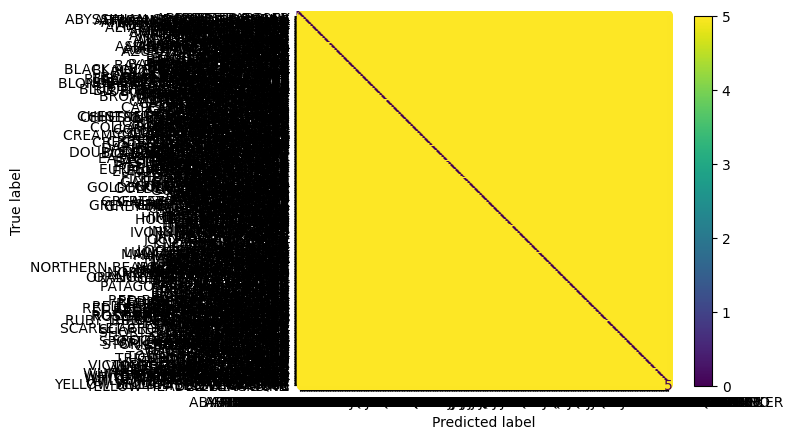

In [19]:
# Display confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=train_dataset.classes)
disp_test.plot()

In [20]:
# Evaluate the model on the test set
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9939


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

# Thiết lập các tham số
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Đường dẫn đến tập dữ liệu
data_dir = "/kaggle/input/100-bird-species/"

# Áp dụng các biến đổi cho dữ liệu huấn luyện và kiểm thử
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Tạo DataLoader cho dữ liệu huấn luyện và kiểm thử 
# ImageFolder => label encoder already included
train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=transform_train)
test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=transform_test)
valid_dataset = datasets.ImageFolder(root=data_dir + 'valid', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Số lượng mẫu
len(train_dataset)

# Print all the classes
classes = train_dataset.classes
print("Len of train Classes:",len(classes))
print("Len of test Classes:",len(test_dataset.classes))

# Get the class-to-index mapping
class_to_idx = train_dataset.class_to_idx

# Print classes with their indices
for class_name, class_idx in class_to_idx.items():
    print(f"Class: {class_name}, Index: {class_idx}")
    
# In input và labels của batch đầu tiên
for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Print the current batch
    print(f"Batch {batch_idx + 1} - Inputs: {inputs}, Labels: {labels}")

    # Print the size of the current batch (number of samples in the batch)
    print(f"Batch {batch_idx + 1} - Batch Size: {len(inputs)}")

    # Break after printing the first 5 batches
    if batch_idx == 0:
        break
        
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict
    
train_metrics = Metrics(["accuracy_score","f1_score"])
valid_metrics = Metrics(["accuracy_score","f1_score"])

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.optim import lr_scheduler

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.dim = dim

    def forward(self, pred, target):
        target = F.one_hot(target, num_classes=pred.size(-1))
        target = target.float()
        target = (1 - self.smoothing) * target + self.smoothing / pred.size(-1)
        log_pred = F.log_softmax(pred, dim=self.dim)
        loss = nn.KLDivLoss(reduction='batchmean')(log_pred, target)
        return loss
        
# Chuyển mô hình và dữ liệu sang GPU nếu có sẵn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

# EfficientNet-B4 architecture from the torchvision library and modifying its classifier for transfer learning. 
# freezing the pre-trained weights of the base model and replacing the classifier with custom classifier.

# Download the weights manually
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth")

# Create the model
model = models.efficientnet_b4(pretrained=True).to(device)

# Load the weights
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False
    # freeze tất cả trọng số của model gốc
classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=256,bias=True),
    nn.Linear(in_features=256, out_features=525,bias=True)
)
model.classifier  = classifier


# Định nghĩa hàm loss và optimizer
#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingLoss(smoothing=0.12)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Apply learning rate scheduling
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Len of train Classes: 525
Len of test Classes: 525
Class: ABBOTTS BABBLER, Index: 0
Class: ABBOTTS BOOBY, Index: 1
Class: ABYSSINIAN GROUND HORNBILL, Index: 2
Class: AFRICAN CROWNED CRANE, Index: 3
Class: AFRICAN EMERALD CUCKOO, Index: 4
Class: AFRICAN FIREFINCH, Index: 5
Class: AFRICAN OYSTER CATCHER, Index: 6
Class: AFRICAN PIED HORNBILL, Index: 7
Class: AFRICAN PYGMY GOOSE, Index: 8
Class: ALBATROSS, Index: 9
Class: ALBERTS TOWHEE, Index: 10
Class: ALEXANDRINE PARAKEET, Index: 11
Class: ALPINE CHOUGH, Index: 12
Class: ALTAMIRA YELLOWTHROAT, Index: 13
Class: AMERICAN AVOCET, Index: 14
Class: AMERICAN BITTERN, Index: 15
Class: AMERICAN COOT, Index: 16
Class: AMERICAN DIPPER, Index: 17
Class: AMERICAN FLAMINGO, Index: 18
Class: AMERICAN GOLDFINCH, Index: 19
Class: AMERICAN KESTREL, Index: 20
Class: AMERICAN PIPIT, Index: 21
Class: AMERICAN REDSTART, Index: 22
Class: AMERICAN ROBIN, Index: 23
Class: AMERICAN WIGEON, Index: 24
Class: AMETHYST WOODSTAR, Index: 25
Class: ANDEAN GOOSE, Inde

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
